# Optimizing Affine Transforms with Gradient Descent and Random Restarts
http://ingmec.ual.es/~jlblanco/papers/jlblanco2010geometry3D_techrep.pdf

We are working with 3d rotations, speical orthogonal group, $SO(3)$. To include translations we extend the transfrom from a 3x3 matrix to to include a fourth homogeneous coodinate, so given a rotation matrix $R \in SO(3)$, and a rotation/translation matrix

$$\
T = \begin{array}{c|c}
\mathbf{R} &
 \begin{array}{c}
   t_x \\ t_y \\ t_z
 \end{array} \\
\hline
 \begin{array}{ccc}
  0 & 0 & 0
 \end{array}
 &
 1\end{array}
 $$

The transformation will be of the form $T(a) = R(a) +  \begin{bmatrix} t_x & t_y & t_z  \end{bmatrix}$, and is called the special Euclidean Group $SE(3)$ 

There are $6$ degrees of freedom in this matrix, so the transformation can alternatively be represented as $6d$ poses, in the form of rotation angles $\begin{bmatrix} r_x & r_y & r_z  \end{bmatrix}$ and translation distances $\begin{bmatrix} t_x & t_y & t_z  \end{bmatrix}$

In [1]:
import os
import math
import random
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib
matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import StepLR

import kaolin as kal
from kaolin.datasets import ModelNet, ModelNetVoxels

# from models import *
from dataset.trans_model_net_voxels import TransformedModelNetVoxels
from utils_3d import pad_3d, affine_transform, get_affine_matrix

%reload_ext autoreload
%autoreload 2
%matplotlib inline

device = 'cuda:0'
modelnet_path = './data/ModelNet10'

## Optimizing Rotations with SGD
* Is gradient descent alone able to optimize a transform?
* We will start with an object, and try to transform it to some goal orientation, where the loss will be MSE
* Objects may have different characteristics, we'll try chair and desk
* Need to make everything nice and differentiable

In [2]:
def pad_for_transform(x, max_trans=.4, rot_factor=1.1):
    """pad the input and adjust the scaling and translation so the object stays withing the boundary
    Default is 40% translation, and scale object by this. 
    Factor of 1.1 added because of rotations (worst case would need 1.4)
    Assume scaling==1
    
    weirdly in pytorch you use scale as 1/scale, and translation as relative amount of translation
    """
    assert transform['scale'] == 1.0
    pad_factor = np.round(rot_factor * (1.0+max_trans), decimals=1)
    x_pad = pad_3d(x, pad_factor=pad_factor)
        
    # Final translation is adjusted to be in terms of final object which is increased by pad_factor
    transform['trans'] =  np.array(transform['trans']) / pad_factor

    return x_pad

In [3]:
def make_rot(r, device) : 
    """ https://discuss.pytorch.org/t/affine-transformation-detection-from-images/29711/7 
    Make a rotation matrix from 3 tensors of dimension [1]
    representing the angle in radians around X, Y and Z axes in this
    order. It seems very verbose but this really does seem to work.
    """
#     r = torch.FloatTensor(r)*math.pi/180.
    x_rot, y_rot, z_rot = r.to(device)

    x_sin = torch.sin(x_rot)
    x_cos = torch.cos(x_rot)

    y_sin = torch.sin(y_rot)
    y_cos = torch.cos(y_rot)

    z_sin = torch.sin(z_rot)
    z_cos = torch.cos(z_rot)

    x_sin_mask = torch.tensor([[0,0,0,0],\
      [0,0,-1,0],
      [0,1,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    x_cos_mask = torch.tensor([[0,0,0,0],\
      [0,1,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    y_sin_mask = torch.tensor([[0,0,1,0],\
      [0,0,0,0],
      [-1,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    y_cos_mask = torch.tensor([[1,0,0,0],\
      [0,0,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    z_sin_mask = torch.tensor([[0,-1,0,0],\
      [1,0,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    z_cos_mask = torch.tensor([[1,0,0,0],\
      [0,1,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    base_x = torch.tensor([[1,0,0,0],\
      [0,0,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    base_y = torch.tensor([[0,0,0,0],\
      [0,1,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    base_z = torch.tensor([[0,0,0,0],\
      [0,0,0,0],\
      [0,0,1,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    rot_x = x_cos.expand_as(x_cos_mask) * x_cos_mask +\
      x_sin.expand_as(x_sin_mask) * x_sin_mask + base_x

    rot_y = y_cos.expand_as(y_cos_mask) * y_cos_mask +\
      y_sin.expand_as(y_sin_mask) * y_sin_mask + base_y

    rot_z = z_cos.expand_as(z_cos_mask) * z_cos_mask +\
      z_sin.expand_as(z_sin_mask) * z_sin_mask + base_z

    rot_mat = torch.matmul(torch.matmul(rot_x, rot_y), rot_z)[:3, :4]
    return rot_mat.unsqueeze(0)

def optimize_rotation(x, x_goal, rot):
    optimizer = optim.Adam([rot], lr=.03)
    for i in range(20):
        rot_mat = make_rot(rot, device=x.device)
        x_affine = affine_transform(x, rot_mat)
        loss = F.mse_loss(x_affine, x_goal, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), rot_mat, rot

## See how rotation optimization works

In [4]:
def visualize_optimization(x, affine_trans_dicts, device):
    nrows, ncols = len(affine_trans_dicts), 3
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows, 1): 
        # Grab the new x
        x_pad = pad_3d(x, pad_factor=1.5).detach()
        r_init = torch.tensor([0., 0., 0.], requires_grad=True)
        x_goal = affine_transform(x_pad, affine_mat=make_rot(torch.FloatTensor(affine_trans_dicts[idx]['rot']), device))
        loss, rot_mat, rot  = optimize_rotation(x_pad, x_goal, r_init)
        x_final = affine_transform(x_pad, affine_mat=rot_mat)
        x_pad = x_pad > .5
        x_goal = x_goal > .5
        x_final = x_final > .5   
        rot = (180.*rot/math.pi).detach().numpy()
        objective_rot = (180.*np.array(affine_trans_dicts[idx]["rot"])/math.pi)
        
        ax = fig.add_subplot(nrows, ncols, 3*idx + 1, projection='3d')
        ax.voxels(x_pad.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title('Initial', fontsize='large')
        ax.axis('off')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 2, projection='3d')
        ax.voxels(x_final.squeeze(), facecolors='blue', edgecolor='k')    
        ax.set_title(f'Result: {rot[0]:.1f}$^\circ$', fontsize='large')
        ax.axis('off')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 3, projection='3d')
        ax.voxels(x_goal.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title(f'Objective: {objective_rot[0]:.1f}$^\circ$', fontsize='large')
        ax.axis('off')
    fig.tight_layout()

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 31803.94it/s]


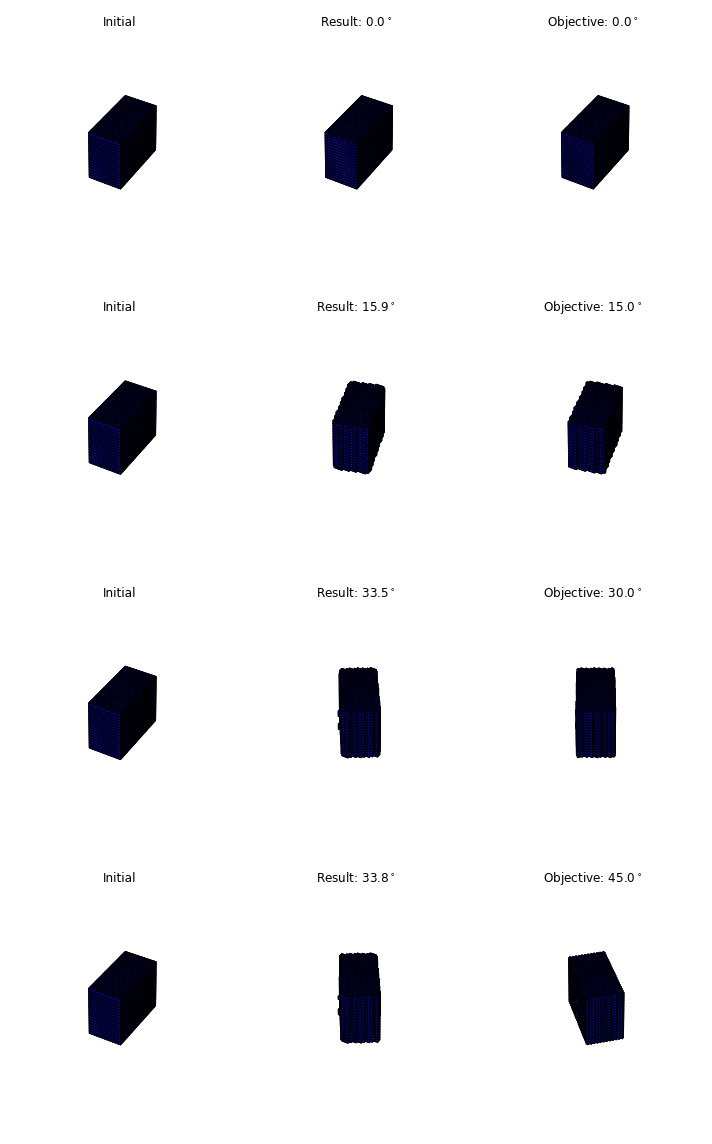

In [5]:
affine_objectives = [
    {'rot': [0, 0, 0]}, 
    {'rot': [math.pi/12, 0, 0]},
    {'rot': [math.pi/6, 0, 0]},
    {'rot': [math.pi/4, 0, 0]},
]

categories = ['dresser']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=4)
batch = next(iter(train_loader))
x = batch['data']['32'][1, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

visualize_optimization(x, affine_objectives, device)

converting to voxels to resolution 32: 100%|██████████| 889/889 [00:00<00:00, 30298.42it/s]


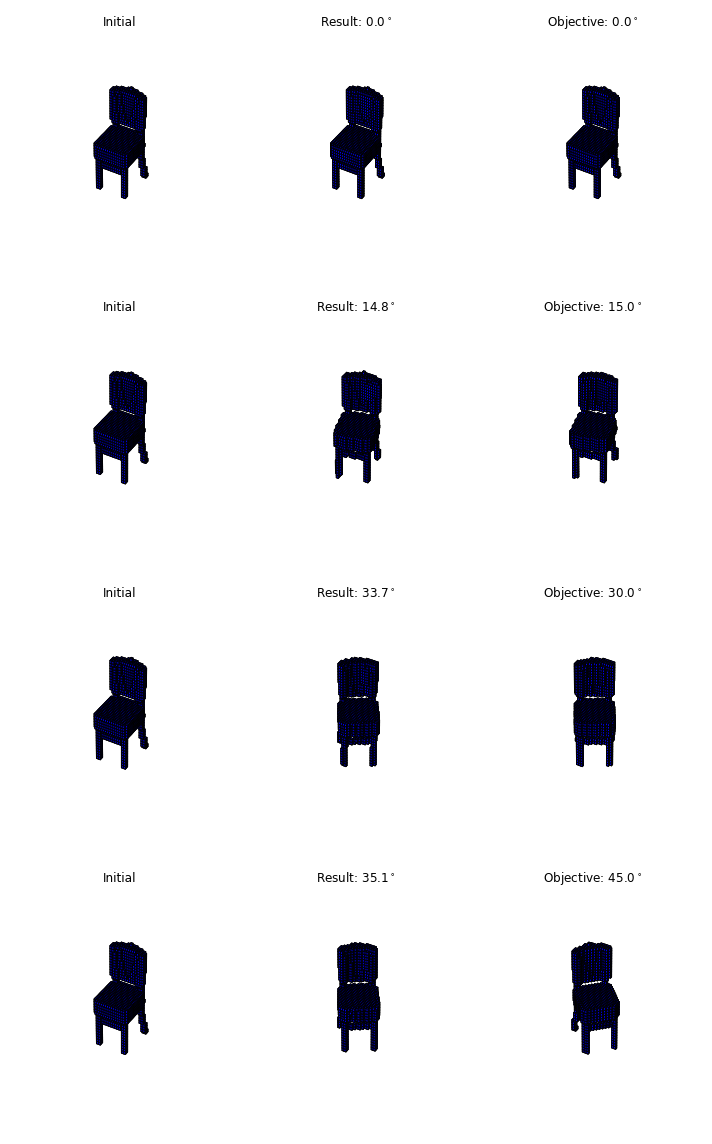

In [6]:
categories = ['chair']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=4)
batch = next(iter(train_loader))
x = batch['data']['32'][2, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

visualize_optimization(x, affine_objectives, device)

## Validating rotation optimization
* For each object class, try a set of rotations (30, 45, 60), and record average distance from the objective pose. (computed for x, y and z rotations and averaged)
* Do on training set:
or all rotation? [x, 0, 0], [0, x, 0], [0, 0, x], [x, x, 0], [0, x, x], [x, x, x], and their negatives.


In [14]:
categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 
                   'sofa', 'monitor', 'table', 'toilet', 'bed']

results = pd.DataFrame()
rotations = [math.pi/6, math.pi/4, math.pi/3]

for category in categories:
    trainset = ModelNetVoxels(modelnet_path, categories=[category], resolutions=[32],
                                             split='train', device=device)
    train_loader = DataLoader(trainset, batch_size=1)
    
    category_results = {}
    category_results['category'] = category

    for rotation_angle in rotations:
        total_loss = 0
        rotation = [rotation_angle, 0, 0]#get_rotation_types(rotation_angle):            
        for batch in train_loader:
            x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
            x_pad = pad_3d(x, pad_factor=1.5).detach()
            r_init = torch.tensor([0., 0., 0.], requires_grad=True)
            x_goal = affine_transform(x_pad, affine_mat=make_rot(torch.FloatTensor(rotation), device))
            loss, rot_mat, final_rot  = optimize_rotation(x_pad, x_goal, r_init)
            total_loss += np.abs(rotation[0]-final_rot[0].detach().cpu().numpy())*180./math.pi
        category_results[np.round(180.*rotation_angle/math.pi)] = total_loss/len(train_loader)
    results = results.append(category_results, ignore_index=True)
results.sort_values(30)

converting to voxels to resolution 32: 100%|██████████| 515/515 [00:00<00:00, 35972.33it/s]


,30.0,45.0,60.0,category
8,2.975023,11.388365,28.140522,toilet
5,3.241071,13.151719,30.293393,sofa
9,3.354137,19.850414,47.036978,bed
0,3.598710,15.608806,36.010219,dresser
6,3.708178,14.772918,38.319903,monitor
4,3.868750,18.632764,47.134113,chair
3,4.377371,20.457411,40.710960,bathtub
2,5.456683,25.680022,64.155208,night_stand
1,5.729832,20.369788,36.593526,desk
7,10.508505,30.804977,49.039640,table


## Translations

In [15]:
def make_translation(t, device):
    """kinda insane, but I don't know how to without either messy mask or stack
    Can't directly set elements like x[:, 3] = t
    """
    t = t.to(device)
    identity = torch.tensor([[1,0,0,0],
                             [0,1,0,0],
                             [0,0,1,0]], dtype=torch.float32, device=device)
    tx = t[0]* torch.tensor([[0,0,0,1],
                             [0,0,0,0],
                             [0,0,0,0]], dtype=torch.float32, device=device)
    ty = t[1]* torch.tensor([[0,0,0,0],
                             [0,0,0,1],
                             [0,0,0,0]], dtype=torch.float32, device=device)
    tz = t[2]* torch.tensor([[0,0,0,0],
                             [0,0,0,0],
                             [0,0,0,1]], dtype=torch.float32, device=device)
    t = identity + tx + ty + tz
    return t.unsqueeze(0)

def optimize_translation(x, x_goal, t_init=torch.tensor([0., 0., 0.], requires_grad=True)):
    optimizer = optim.Adam([t_init], lr=.03)
    for i in range(20):
        t_mat = make_translation(t_init, device=x.device)
        x_affine = affine_transform(x, t_mat)
        loss = F.mse_loss(x_affine, x_goal, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), t_mat, t_init

def visualize_trans_opt(x, affine_trans_dicts, device):
    nrows, ncols = len(affine_trans_dicts), 3
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows, 1): 
        # Grab the new x
        x_pad = pad_3d(x, pad_factor=1.5).detach()
        x_goal = affine_transform(x_pad, affine_mat=make_translation(torch.FloatTensor(affine_trans_dicts[idx]['trans']), device))
        loss, mat, trans  = optimize_translation(x_pad, x_goal)
        x_final = affine_transform(x_pad, affine_mat=mat)
        print('obj', [f"{i:.2f}" for i in affine_trans_dicts[idx]['trans']])
        print('trans', [f"{i:.2f}" for i in trans.squeeze().cpu().detach().numpy()])
        x_pad = x_pad > .5
        x_goal = x_goal > .5
        x_final = x_final > .5   
        
        ax = fig.add_subplot(nrows, ncols, 3*idx + 1, projection='3d')
        ax.voxels(x_pad.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title('Initial', fontsize='large')
#         ax.axis('off')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 2, projection='3d')
        ax.voxels(x_final.squeeze(), facecolors='blue', edgecolor='k')    
        ax.set_title(f'Result: {[f"{i:.1f}" for i in trans]}', fontsize='large')
#         ax.axis('off')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 3, projection='3d')
        ax.voxels(x_goal.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title(f'Objective: {[f"{i:.1f}" for i in affine_trans_dicts[idx]["trans"]]}', fontsize='large')
#         ax.axis('off')
    fig.tight_layout()

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 30236.85it/s]


obj ['0.00', '0.00', '0.00']
trans ['0.00', '0.00', '0.00']
obj ['0.10', '0.00', '0.00']
trans ['0.08', '0.01', '0.01']
obj ['0.20', '0.00', '0.00']
trans ['0.22', '-0.00', '-0.00']
obj ['0.20', '0.20', '0.20']
trans ['0.19', '0.26', '0.26']


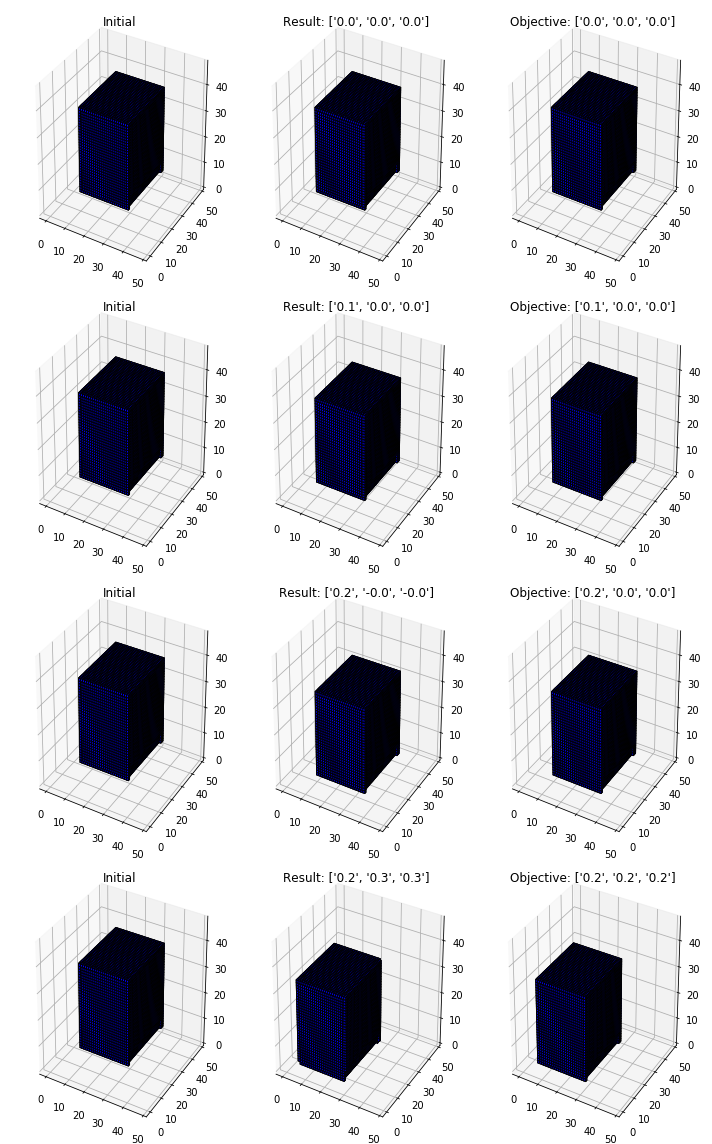

In [16]:
affine_objectives = [
    {'trans': [0, 0, 0]},
    {'trans': [.1, 0, 0]},
    {'trans': [.2, 0, 0]},
    {'trans': [.2, .2, .2]},
]

modelnet_path = './data/ModelNet10'
categories = ['dresser']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=1)
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

visualize_trans_opt(x, affine_objectives, device)

#### How does it depend on object class?

In [17]:
categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 
                   'sofa', 'monitor', 'table', 'toilet', 'bed']

results = pd.DataFrame()
translations = [.1, .2, .3]

for category in categories:
    trainset = ModelNetVoxels(modelnet_path, categories=[category], resolutions=[32],
                                             split='train', device=device)
    train_loader = DataLoader(trainset, batch_size=1)
    
    category_results = {}
    category_results['category'] = category

    for translation in translations:
        translation = [translation, 0, 0]         
        total_loss = 0
        for batch in train_loader:
            x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
            x_pad = pad_3d(x, pad_factor=1.5).detach()
            x_goal = affine_transform(x_pad, affine_mat=make_translation(torch.FloatTensor(translation), device))
            loss, mat, final_trans  = optimize_translation(x_pad, x_goal)        
            total_loss += np.abs(translation[0]-final_trans[0].detach().cpu().numpy())
        category_results[translation[0]] = total_loss/len(train_loader)
    results = results.append(category_results, ignore_index=True)
results.sort_values(.1)

converting to voxels to resolution 32: 100%|██████████| 515/515 [00:00<00:00, 37965.84it/s]


,0.1,0.2,0.3,category
5,0.003251,0.004483,0.004353,sofa
9,0.003750,0.005083,0.005028,bed
0,0.003969,0.005285,0.005302,dresser
2,0.004044,0.005395,0.005474,night_stand
8,0.004058,0.004352,0.004214,toilet
6,0.004650,0.005030,0.004873,monitor
4,0.004730,0.004516,0.004561,chair
1,0.006138,0.006217,0.006700,desk
3,0.006887,0.005002,0.006687,bathtub
7,0.008424,0.006373,0.006848,table


## Affine Transforms

In [18]:
def make_affine(r, t, device) : 
    t = t.to(device)
    x_rot, y_rot, z_rot = r.to(device)
    identity = torch.tensor([[1,0,0,0],
                             [0,1,0,0],
                             [0,0,1,0]], dtype=torch.float32, device=device)
    tx = t[0]* torch.tensor([[0,0,0,1],
                             [0,0,0,0],
                             [0,0,0,0]], dtype=torch.float32, device=device)
    ty = t[1]* torch.tensor([[0,0,0,0],
                             [0,0,0,1],
                             [0,0,0,0]], dtype=torch.float32, device=device)
    tz = t[2]* torch.tensor([[0,0,0,0],
                             [0,0,0,0],
                             [0,0,0,1]], dtype=torch.float32, device=device)

    x_sin_mask = torch.tensor([[0,0,0,0],\
      [0,0,-1,0],
      [0,1,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    x_cos_mask = torch.tensor([[0,0,0,0],\
      [0,1,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    y_sin_mask = torch.tensor([[0,0,1,0],\
      [0,0,0,0],
      [-1,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    y_cos_mask = torch.tensor([[1,0,0,0],\
      [0,0,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    z_sin_mask = torch.tensor([[0,-1,0,0],\
      [1,0,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    z_cos_mask = torch.tensor([[1,0,0,0],\
      [0,1,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device)

    base_x = torch.tensor([[1,0,0,0],\
      [0,0,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    base_y = torch.tensor([[0,0,0,0],\
      [0,1,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    base_z = torch.tensor([[0,0,0,0],\
      [0,0,0,0],\
      [0,0,1,0],\
      [0,0,0,1]], dtype=torch.float32, device = device)

    rot_x = torch.cos(x_rot) * x_cos_mask + torch.sin(x_rot) * x_sin_mask + base_x
    rot_y = torch.cos(y_rot) * y_cos_mask + torch.sin(y_rot) * y_sin_mask + base_y
    rot_z = torch.cos(z_rot) * z_cos_mask + torch.sin(z_rot) * z_sin_mask + base_z

    rot_mat = torch.matmul(torch.matmul(rot_x, rot_y), rot_z)[:3, :4]
    affine_mat = rot_mat + tx + ty + tz
    return affine_mat.unsqueeze(0)

def optimize_affine(x, x_goal, 
                    r_init=torch.tensor([0., 0., 0.], requires_grad=True), 
                    t_init=torch.tensor([0., 0., 0.], requires_grad=True)):
    
    optimizer = optim.Adam([r_init, t_init], lr=.03)
    for i in range(20):
        affine_mat = make_affine(r=r_init, t=t_init, device=x.device)
        x_affine = affine_transform(x, affine_mat)
        loss = F.mse_loss(x_affine, x_goal, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item(), affine_mat, r_init, t_init

def visualize_affine_opt(x, affine_trans_dicts, device):
    nrows, ncols = len(affine_trans_dicts), 3
    fig = plt.figure(figsize=(10, nrows*4))
    for idx in range(0, nrows, 1): 
        # Grab the new x
        x_pad = pad_3d(x, pad_factor=1.5).detach()
        x_goal = affine_transform(x_pad, affine_mat=make_affine(r=torch.FloatTensor(affine_trans_dicts[idx]['rot']),
                                                                t=torch.FloatTensor(affine_trans_dicts[idx]['trans']),
                                                                device=device))
        loss, mat, r, t  = optimize_affine(x_pad, x_goal)
        x_final = affine_transform(x_pad, affine_mat=mat)
        
        x_pad = x_pad > .5
        x_goal = x_goal > .5
        x_final = x_final > .5   
        ax = fig.add_subplot(nrows, ncols, 3*idx + 1, projection='3d')
        ax.voxels(x_pad.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title('Initial', fontsize='large')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 2, projection='3d')
        ax.voxels(x_final.squeeze(), facecolors='blue', edgecolor='k')   
        nl = '\n' 
        ax.set_title(f'Result: r:{[f"{i:.1f}" for i in r]}{nl} t:{[f"{i:.1f}" for i in t]}', fontsize='large')
        ax = fig.add_subplot(nrows, ncols, 3*idx + 3, projection='3d')
        ax.voxels(x_goal.squeeze(), facecolors='blue', edgecolor='k')
        ax.set_title(f'Obj, r:{[f"{i:.1f}" for i in affine_trans_dicts[idx]["rot"]]}{nl} t:{[f"{i:.1f}" for i in affine_trans_dicts[idx]["trans"]]}', fontsize='large')
    fig.tight_layout()

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 33652.70it/s]


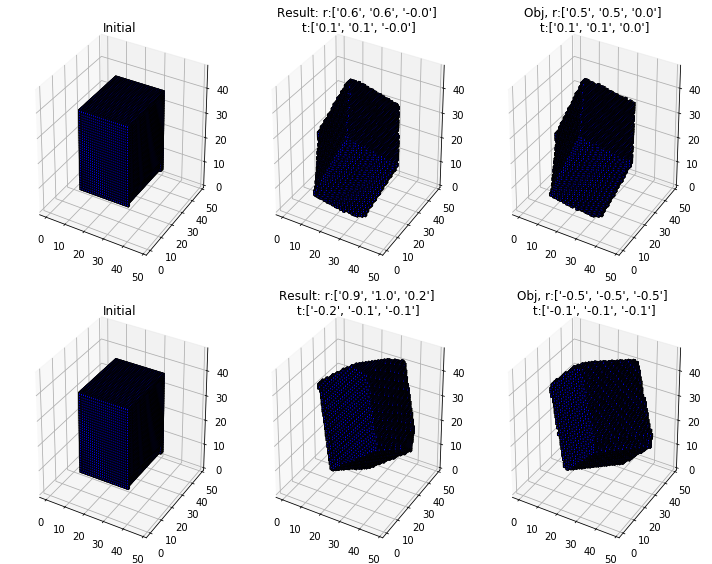

In [19]:
affine_objectives = [
    {'rot': [math.pi/6, math.pi/6, 0],
     'trans': [.1, .1, 0]},
    {'rot': [-math.pi/6, -math.pi/6, -math.pi/6],
     'trans': [-.1, -.1, -.1]},
]

categories = ['dresser']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=1)
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

visualize_affine_opt(x, affine_objectives, device)

## Optimization with Random Restarts
Above results show that differentiable optimization works resonably well, but inconsistently:
* Better for simple shapes (dresser vs. table)
* Better for translations than rotations
* Limited to smaller rotations (<45 degrees)

Because of this we need to use another method to ensure the optimization isn't caught in a local optimum. 

Note there's a bunch of better ways to do optimization, but we choose something simple. We want it to be easily parallelizable. It's relatively fast to a forward pass on a bunch of parameters, but slow to do things sequentially. So we'll randomly sample n_rand parameters, and do SGD on the top n_sgd of them.

In [20]:
def make_affine(r, t, device):
    """Batch version"""
    assert r.size() == t.size()
    if len(r.size()) == 1: # bs=1
        r = r.unsqueeze(0)
        t = t.unsqueeze(0)
    n, _ = r.size()
    t = t.to(device)
    r = r.to(device)
    identity = torch.tensor([[1,0,0,0],
                             [0,1,0,0],
                             [0,0,1,0]], dtype=torch.float32, device=device).view(1,3,4).repeat(n, 1, 1)
    tx = t[:, 0].view(-1,1,1).repeat(1,3,4)*torch.tensor([[0,0,0,1],
                                                         [0,0,0,0],
                                                         [0,0,0,0]], dtype=torch.float32, device=device
                                                        ).view(1,3,4).repeat(n, 1, 1)
    ty = t[:, 1].view(-1,1,1).repeat(1,3,4)*torch.tensor([[0,0,0,0],
                                                         [0,0,0,1],
                                                         [0,0,0,0]], dtype=torch.float32, device=device
                                                          ).view(1,3,4).repeat(n, 1, 1)
    tz = t[:, 2].view(-1,1,1).repeat(1,3,4)*torch.tensor([[0,0,0,0],
                                                         [0,0,0,0],
                                                         [0,0,0,1]], dtype=torch.float32, device=device
                                                        ).view(1,3,4).repeat(n, 1, 1)
    x_sin_mask = torch.tensor([[0,0,0,0],\
      [0,0,-1,0],
      [0,1,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    x_cos_mask = torch.tensor([[0,0,0,0],\
      [0,1,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    y_sin_mask = torch.tensor([[0,0,1,0],\
      [0,0,0,0],
      [-1,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    y_cos_mask = torch.tensor([[1,0,0,0],\
      [0,0,0,0],
      [0,0,1,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    z_sin_mask = torch.tensor([[0,-1,0,0],\
      [1,0,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    z_cos_mask = torch.tensor([[1,0,0,0],\
      [0,1,0,0],
      [0,0,0,0],
      [0,0,0,0]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    base_x = torch.tensor([[1,0,0,0],\
      [0,0,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    base_y = torch.tensor([[0,0,0,0],\
      [0,1,0,0],\
      [0,0,0,0],\
      [0,0,0,1]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)
    base_z = torch.tensor([[0,0,0,0],\
      [0,0,0,0],\
      [0,0,1,0],\
      [0,0,0,1]], dtype=torch.float32, device = device).view(1,4,4).repeat(n, 1, 1)

    rot_x = torch.cos(r[:, 0].view(-1, 1, 1).repeat(1,4,4)) * x_cos_mask + \
            torch.sin(r[:, 0].view(-1, 1, 1).repeat(1,4,4)) * x_sin_mask + base_x
    rot_y = torch.cos(r[:, 1].view(-1, 1, 1).repeat(1,4,4)) * y_cos_mask + \
            torch.sin(r[:, 1].view(-1, 1, 1).repeat(1,4,4)) * y_sin_mask + base_y
    rot_z = torch.cos(r[:, 2].view(-1, 1, 1).repeat(1,4,4)) * z_cos_mask + \
            torch.sin(r[:, 2].view(-1, 1, 1).repeat(1,4,4)) * z_sin_mask + base_z

    rot_mat = torch.bmm(torch.bmm(rot_x, rot_y), rot_z)[:, :3, :4]    
    affine_mat = rot_mat + tx + ty + tz
    return affine_mat

In [21]:
def rand_opt(x, x_goal, n_affine=16):
    """n_affine is number of random restarts
    BS =1 only!
    """
    bs, ch, _, _, _ = x.size()
    r_init = torch.ones([n_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
    t_init = torch.ones([n_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
    
    with torch.no_grad():
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        
        # repeat in batch dim, so bs*n_affine:
        x_rep = x.repeat(n_affine, 1, 1, 1, 1)
        xg_rep = x_goal.repeat(n_affine, 1, 1, 1, 1)
        
        affine_params_rep = affine_params.repeat(bs, 1, 1).view(bs*n_affine, 3, 4).to(x.device)

        # "forward pass", and sum loss per example
        x_affine = affine_transform(x_rep, affine_params_rep)
        loss = F.mse_loss(x_affine, xg_rep, reduction='none').sum((-3, -2, -1))
        loss = loss.view(n_affine, bs, 1)
        best_loss, best_param_idx = torch.min(loss, dim=0)

        # select the params, x_affine, corresponding to lowest loss
        affine_params_rep = affine_params_rep.view(n_affine, bs, 3, 4)

        x_affine = x_affine.view(n_affine, bs, 1, x_affine.size(-3), x_affine.size(-2), x_affine.size(-1))
        x_affine_best = x_affine[best_param_idx.squeeze(), torch.arange(bs), :, :, :, :]
        best_affine_params = affine_params_rep[best_param_idx.squeeze(), torch.arange(bs), :, :]
    return best_loss, best_affine_params

In [22]:
categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 
                   'sofa', 'monitor', 'table', 'toilet', 'bed']

results = pd.DataFrame()
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

for n_affine in [4, 16, 64, 256]:
    for category in categories:
        trainset = ModelNetVoxels(modelnet_path, categories=[category], resolutions=[32],
                                   split='train', device=device)
        train_loader = DataLoader(trainset, batch_size=1)
        category_results = {}
        category_results['category'] = category
        for affine_idx, affine_dict in enumerate(affine_objectives):
            total_loss = 0
            for batch in train_loader:
                x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                x_goal = affine_transform(x_pad, affine_mat=get_affine_matrix(**affine_dict))
                loss, affine_params = rand_opt(x_pad, x_goal, n_affine=n_affine)
                total_loss += loss.item()
            category_results[affine_idx] = total_loss/len(train_loader)
        results = results.append(category_results, ignore_index=True)
    print(f'{n_affine} random restarts, average loss: {np.mean(results.values[:, :3])}')

converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 32914.57it/s]

4 random restarts, average loss: 5055.853900967946



converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 32949.48it/s]

16 random restarts, average loss: 4756.269339771347



converting to voxels to resolution 32: 100%|██████████| 200/200 [00:00<00:00, 32835.98it/s]

64 random restarts, average loss: 4473.17380801503



converting to voxels to resolution 32: 100%|██████████| 515/515 [00:00<00:00, 37043.89it/s]


256 random restarts, average loss: 4211.164340760824


In [23]:
results

,0,1,2,category
0,7864.690152,7801.889633,8880.194382,dresser
1,4447.922885,4057.751825,4393.371310,desk
2,9024.771420,8713.317352,10076.995729,night_stand
3,3499.953788,3157.804812,3348.707278,bathtub
4,2859.028425,2558.972257,2612.190201,chair
5,3988.413373,4048.456918,4189.405574,sofa
6,4367.433102,4134.404480,4313.386670,monitor
7,3069.395681,2698.328964,2806.375661,table
8,6243.073888,6131.799786,6489.439750,toilet
9,5318.206066,5337.239048,5242.696619,bed


## Random Restarts + SGD
* Above result shows random restarts is working.
* Do gradient descent on the best random restarts

In [24]:
def rand_sgd_opt(x, x_goal, n_sgd=4, n_total_affine=16):
    """ BS=1 !
    n_affine is number of random restarts
    """
    bs, ch, _, _, _ = x.size()
    assert bs==1
    r_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
    t_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
    
    with torch.no_grad():
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        
        # repeat in batch dim, so bs*n_affine:
        x_rep = x.repeat(n_total_affine, 1, 1, 1, 1)
        xg_rep = x_goal.repeat(n_total_affine, 1, 1, 1, 1)

        # "forward pass", and sum loss per example
        x_affine = affine_transform(x_rep, affine_params)
        loss = F.mse_loss(x_affine, xg_rep, reduction='none')
        loss = loss.sum((-3, -2, -1)).squeeze()
        best_loss, best_param_idx = torch.topk(loss, k=n_sgd, largest=False)
        
    # SGD TIME - Select best params and get rid of old params so no grad or memory issues
    del x_affine, x_rep, xg_rep
    r_init = r_init[best_param_idx, :].clone().detach().requires_grad_(True)
    t_init = t_init[best_param_idx, :].clone().detach().requires_grad_(True)
    
    x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
    xg_rep = x_goal.repeat(n_sgd, 1, 1, 1, 1)
    optimizer = optim.Adam([r_init, t_init], lr=.01)

    for i in range(25):
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        x_affine = affine_transform(x_rep, affine_params)        
        loss = F.mse_loss(x_affine, xg_rep, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = F.mse_loss(x_affine, xg_rep, reduction='none')
    loss = loss.sum((-3, -2, -1)).squeeze()
    best_loss, best_param_idx = torch.min(loss, dim=0)
#     print('final best loss: ', best_loss.item())
    return best_loss, affine_params[best_param_idx, :, :].unsqueeze(0), r_init[best_param_idx], t_init[best_param_idx]

In [ ]:
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

__BS = 16 # skip a bunch of examples to make it faster

categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 'sofa', 'monitor', 'table', 'toilet', 'bed']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                           split='train', device=device)
train_loader = DataLoader(trainset, batch_size=__BS)

n_sgd_list = [2, 4, 8, 16]
n_total_affine_list = [16, 32, 64]
results = pd.DataFrame(columns=n_sgd_list, index=n_total_affine_list)

for n_total_affine in n_total_affine_list:
    for n_sgd in n_sgd_list:
        if n_total_affine < n_sgd: 
            continue
            
        total_loss = 0
        for affine_idx, affine_dict in enumerate(affine_objectives):
            for batch in train_loader:
                x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                x_goal = affine_transform(x_pad, affine_mat=get_affine_matrix(**affine_dict))
                loss, affine_params, r, t = rand_sgd_opt(x_pad, x_goal, n_sgd=n_sgd, n_total_affine=n_total_affine)
                total_loss += loss.item()
        results.at[n_sgd, n_total_affine] = total_loss/len(train_loader)
        print(f'Inits: {n_total_affine}, SGD on top {n_sgd}, average loss: {total_loss/len(train_loader)}')
results

converting to voxels to resolution 32: 100%|██████████| 3991/3991 [00:00<00:00, 34064.09it/s]


Inits: 16, SGD on top 2, average loss: 8181.239803268432
Inits: 16, SGD on top 4, average loss: 7893.622119873047
Inits: 16, SGD on top 8, average loss: 7671.9567988128665
Inits: 16, SGD on top 16, average loss: 7265.360639877319


In [ ]:
categories = ['sofa']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                                         split='train', device=device)
train_loader = DataLoader(trainset, batch_size=1)
batch = next(iter(train_loader))
x = batch['data']['32'][0, :, :, :].to(device).unsqueeze(0).unsqueeze(0)

affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

nrows, ncols = len(affine_objectives), 3
fig = plt.figure(figsize=(12, nrows*4))
for idx in range(0, nrows, 1): 
    # Grab the new x
    x_pad = pad_3d(x, pad_factor=1.5).detach()
    x_goal = affine_transform(x_pad, affine_mat=make_affine(r=torch.FloatTensor(affine_objectives[idx]['rot']),
                                                            t=torch.FloatTensor(affine_objectives[idx]['trans']),
                                                            device=device))
    loss, affine_params, r, t = rand_sgd_opt(x_pad, x_goal, n_sgd=8, n_total_affine=64)
    x_final = affine_transform(x_pad, affine_mat=affine_params)

    x_pad = x_pad > .5
    x_goal = x_goal > .5
    x_final = x_final > .5   
    ax = fig.add_subplot(nrows, ncols, 3*idx + 1, projection='3d')
    ax.voxels(x_pad.squeeze(), facecolors='blue', edgecolor='k')
    ax.set_title('Initial', fontsize='large')
    ax = fig.add_subplot(nrows, ncols, 3*idx + 2, projection='3d')
    ax.voxels(x_final.squeeze(), facecolors='blue', edgecolor='k')   
    nl = '\n' 
    ax.set_title(f'Result: r:{[f"{i:.1f}" for i in r]}{nl} t:{[f"{i:.1f}" for i in t]}', fontsize='large')
    ax = fig.add_subplot(nrows, ncols, 3*idx + 3, projection='3d')
    ax.voxels(x_goal.squeeze(), facecolors='blue', edgecolor='k')
    ax.set_title(f'Obj, r:{[f"{i:.1f}" for i in affine_objectives[idx]["rot"]]}{nl} t:{[f"{i:.1f}" for i in affine_objectives[idx]["trans"]]}', fontsize='large')
fig.tight_layout()

## Results
We want to use relatively large amount of random restarts, like 64 if possible, and do SGD on only on the best performing ones, like 8 examples. This is computationally expensive, so small batch sizes must be used.

There are better approaches to this like Bayesian optimization or evolution strategies, but we will stick with thsi strategy for simplicty

Doing this batch-wise will be pointless with one GPU because the forward pass with so many samples will take up all the memory

In [74]:
def rand_sgd_opt_batch(x, x_goal, n_sgd=4, n_total_affine=16):
    """
    n_affine is number of random restarts
    """
    bs, ch, _, _, _ = x.size()
    r_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(0, 2*math.pi)
    t_init = torch.ones([n_total_affine, 3], dtype=torch.float32, device=x.device).uniform_(-.2, .2)
    
    with torch.no_grad():
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        
        # repeat in batch dim, so bs*n_affine:
        x_rep = x.repeat(n_total_affine, 1, 1, 1, 1)
        xg_rep = x_goal.repeat(n_total_affine, 1, 1, 1, 1)
        affine_params_rep = affine_params.repeat(bs, 1, 1).view(bs*n_total_affine, 3, 4).to(x.device)
        
        # "forward pass", and get loss per example
        x_affine = affine_transform(x_rep, affine_params_rep)
        loss = F.mse_loss(x_affine, xg_rep, reduction='none')
        loss = loss.sum((-3, -2, -1)).squeeze()
        loss = loss.view(n_total_affine, bs)
        
        best_loss, best_param_idx = torch.topk(loss, dim=0, k=n_sgd, largest=False)
        affine_params_rep = affine_params_rep.view(n_total_affine, bs, 3, 4)
        best_affine_params = affine_params_rep[best_param_idx, torch.arange(bs), :, :]
        best_affine_params = best_affine_params.view(n_sgd*bs, 3, 4)
        
    # SGD TIME - Get rid of old params and re-create so no grad or memory issues
    x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
    xg_rep = x_goal.repeat(n_sgd, 1, 1, 1, 1)
    del x_affine, x_rep, xg_rep
    r_init = r_init[best_param_idx, :].clone().detach().requires_grad_(True)
    t_init = t_init[best_param_idx, :].clone().detach().requires_grad_(True)
    
    x_rep = x.repeat(n_sgd, 1, 1, 1, 1)
    xg_rep = x_goal.repeat(n_sgd, 1, 1, 1, 1)
    optimizer = optim.Adam([r_init, t_init], lr=.01)

    for i in range(25):
        affine_params = make_affine(r=r_init, t=t_init, device=x.device)
        x_affine = affine_transform(x_rep, affine_params)        
        loss = F.mse_loss(x_affine, xg_rep, reduction='sum')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss = F.mse_loss(x_affine, xg_rep, reduction='none')
    loss = loss.sum((-3, -2, -1)).squeeze()
    best_loss, best_param_idx = torch.min(loss, dim=0)
    return best_loss, affine_params[best_param_idx, :, :]

In [75]:
affine_objectives = [
    {'rot': [0, 0, 0],
     'trans': [0, 0, 0]},
    {'rot': [math.pi/6, 0, 0],
     'trans': [.2, 0, 0]},
    {'rot': [-math.pi/4, -math.pi/4, -math.pi/4],
     'trans': [-.2, -.2, -.2]},
]

bs = 4

categories = ['dresser', 'desk', 'night_stand',  'bathtub', 'chair', 'sofa', ]#'monitor', 'table', 'toilet', 'bed']
trainset = ModelNetVoxels(modelnet_path, categories=categories, resolutions=[32],
                           split='train', device=device)
train_loader = DataLoader(trainset, batch_size=bs)

n_sgd_list = [2, 4, 8, 16]
n_total_affine_list = [16, 32, 64]
results = pd.DataFrame(columns=n_sgd_list, index=n_total_affine_list)

for n_total_affine in n_total_affine_list:
    for n_sgd in n_sgd_list:
        if n_total_affine < n_sgd: 
            continue
        total_loss = 0
        for affine_idx, affine_dict in enumerate(affine_objectives):
            for batch in train_loader:
                x = batch['data']['32'].to(device).unsqueeze(1)
                x_pad = pad_3d(x, pad_factor=1.5).detach()
                if x_pad.size() != torch.Size([bs, 1, 48, 48, 48]):
                    print(x.size(), x_pad.size())
                affine_mat = get_affine_matrix(**affine_dict).repeat(bs, 1, 1)
                x_goal = affine_transform(x_pad, affine_mat=affine_mat)
                loss, affine_params = rand_sgd_opt_batch(x_pad, x_goal, n_sgd=n_sgd, n_total_affine=n_total_affine)
                total_loss += loss.item()
        results.at[n_sgd, n_total_affine] = total_loss/len(train_loader)
        print(f'Inits: {n_total_affine}, SGD on top {n_sgd}, average loss: {total_loss/len(train_loader)}')
results

converting to voxels to resolution 32: 100%|██████████| 2275/2275 [00:00<00:00, 29641.95it/s]


torch.Size([3, 1, 32, 32, 32]) torch.Size([3, 1, 48, 48, 48])


RuntimeError: Expected tensor to have size 3 at dimension 0, but got size 4 for argument #2 'batch2' (while checking arguments for bmm)